# Data Preprocessing- Grouping Data

In [77]:
# Import Libraries
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_classif,  f_classif
from sklearn.metrics import plot_confusion_matrix
import zipfile
from pyproj import Proj, transform
import geopandas as gpd
import shapefile
# a nice way of filtering out deprecated warnings
import warnings
import geopandas as gpd
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

## Open Taxi and FHV Datasets

In [2]:
df_taxi= pd.read_feather("../preprocessed_data/feather/yellow_tripdata_2019.feather")
print("df_taxi read")
df_fhv= pd.read_feather("../preprocessed_data/feather/fhv_tripdata_2019.feather")
print("df_fhv read")

df_taxi read
df_fhv read


In [3]:
# open location zone information
dfzone = pd.read_csv("../raw_data/taxi+_zone_lookup.csv")
# open location shapefile
with zipfile.ZipFile(open(r'../data/large/taxi_zones.zip', 'rb')) as zip_ref:
    zip_ref.extractall('../data/large/')
sf = gpd.read_file("../data/large/taxi_zones.shp")

In [4]:
dfweather= pd.read_feather('../preprocessed_data/dfweather.feather')

Since feather file doesn't support datetime datatype, convert it again into datetime

In [5]:
df_taxi['pickup_datetime']= pd.to_datetime(df_taxi['pickup_datetime'])
print("converted pickup to ", type(df_taxi['pickup_datetime'][0]))
df_fhv['pickup_datetime']= pd.to_datetime(df_fhv['pickup_datetime'])
print("converted dropoff to ", type(df_taxi['dropoff_datetime'][0]))

converted pickup to  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
converted dropoff to  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [6]:
train_taxi= df_taxi.loc[df_taxi['pickup_datetime']< pd.Timestamp(datetime(2019, 5, 1))]
print("train_taxi made")
train_fhv= df_fhv.loc[df_fhv['pickup_datetime']< pd.Timestamp(datetime(2019, 5, 1))]
print("train_fhv made")
test_taxi= df_taxi.loc[df_taxi['pickup_datetime']> pd.Timestamp(datetime(2019, 4, 30))]
print("test_taxi made")
test_fhv= df_fhv.loc[df_fhv['pickup_datetime']> pd.Timestamp(datetime(2019, 4, 30))]
print("test_fhv made")

train_taxi made
train_fhv made
test_taxi made
test_fhv made


In [7]:
train_df = train_taxi.append(train_fhv, ignore_index = True)
print("train_df made")
test_df = test_taxi.append(test_fhv, ignore_index = True)
print("test_df made")

train_df made
test_df made


In [8]:
dfweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2774 entries, 0 to 2773
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          2774 non-null   int64   
 1   tempF          2774 non-null   float64 
 2   relhumidity    2774 non-null   float64 
 3   precipitation  2774 non-null   float64 
 4   time session   2774 non-null   category
 5   date           2774 non-null   object  
dtypes: category(1), float64(3), int64(1), object(1)
memory usage: 111.4+ KB


## Group and split data 

In [9]:
print("Null values in training df:")
print(train_df.isnull().sum())
print("Null values in testing df:")
print(test_df.isnull().sum())

Null values in training df:
index                           0
pickup_datetime                 0
dropoff_datetime                0
passenger_count                 0
trip_distance            45411866
PULocationID                    0
DOLocationID                    0
fare_amount              45411866
extra                    45411866
mta_tax                  45411866
tip_amount               45411866
tolls_amount             45411866
improvement_surcharge    45411866
total_amount             45411866
congestion_surcharge     45411866
total_trip_duration             0
avespeed_mileshr         45411866
time session                    0
date                            0
hour                            0
day                             0
dtype: int64
Null values in testing df:
index                           0
pickup_datetime                 0
dropoff_datetime                0
passenger_count                 0
trip_distance            22122416
PULocationID                    0
DOLocationID  

In [10]:
del train_df["index"]
del test_df["index"]

In [11]:
train_df.columns, test_df.columns

(Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
        'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra',
        'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
        'total_amount', 'congestion_surcharge', 'total_trip_duration',
        'avespeed_mileshr', 'time session', 'date', 'hour', 'day'],
       dtype='object'),
 Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
        'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra',
        'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
        'total_amount', 'congestion_surcharge', 'total_trip_duration',
        'avespeed_mileshr', 'time session', 'date', 'hour', 'day'],
       dtype='object'))

In [12]:
train_taxi.columns

Index(['index', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'total_trip_duration',
       'avespeed_mileshr', 'time session', 'date', 'hour', 'day'],
      dtype='object')

In [13]:
#median of training taxi data, returning full median without null
X_train= train_taxi.groupby(['date', 'time session','PULocationID'], as_index= False).median().dropna(subset= ["DOLocationID"])
X_train= X_train.drop(columns= ["DOLocationID", "total_trip_duration", "hour"]) 
print(X_train.shape)
print(X_train["PULocationID"].nunique())
#this includes the part that is a combination of taxi and fhv trips
# with removing parts where DOLocationID is null since that means
# neither fhv data or taxi data are present
X_train_2= train_df.groupby(['date', 'time session','PULocationID'], as_index= False).median().dropna()
X_train_2= X_train_2[['date', 'time session','PULocationID', "DOLocationID","total_trip_duration", "hour"]] 
X_train= pd.merge(X_train, X_train_2, on=['date', 'time session', 'PULocationID'] )
X_train.shape

(23347, 16)
239


(23347, 19)

In [14]:

#del train_taxi
#del train_fhv

In [15]:
X_train.describe().round()

,PULocationID,index,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,avespeed_mileshr,day,DOLocationID,total_trip_duration,hour
count,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0,23347.0
mean,141.0,7825810.0,1.0,4.0,15.0,1.0,0.0,3.0,0.0,0.0,23.0,3.0,13.0,16.0,143.0,16.0,4.0
std,77.0,4417033.0,1.0,4.0,10.0,1.0,0.0,2.0,2.0,0.0,13.0,0.0,5.0,9.0,23.0,4.0,1.0
min,1.0,1021.0,1.0,0.0,3.0,-2.0,0.0,0.0,0.0,0.0,7.0,2.0,1.0,1.0,12.0,3.0,3.0
25%,75.0,4064190.0,1.0,2.0,9.0,0.0,0.0,2.0,0.0,0.0,15.0,2.0,10.0,8.0,138.0,13.0,3.0
50%,143.0,7860542.0,1.0,3.0,12.0,0.0,0.0,3.0,0.0,0.0,18.0,2.0,12.0,16.0,148.0,15.0,4.0
75%,217.0,11721806.0,1.0,5.0,18.0,1.0,0.0,4.0,0.0,0.0,26.0,2.0,15.0,23.0,161.0,17.0,4.0
max,263.0,15260883.0,6.0,37.0,102.0,7.0,0.0,78.0,30.0,0.0,179.0,3.0,47.0,31.0,262.0,76.0,4.0


In [16]:
X_train['date']= pd.to_datetime(X_train['date'])
dfweather['date']= pd.to_datetime(dfweather['date'])

In [17]:
dfweather= dfweather.groupby(['date', 'time session'], as_index= False).mean()

In [18]:
X_train= pd.merge(X_train, dfweather, on= ["date", "time session"])
X_train.columns, X_train.shape

(Index(['date', 'time session', 'PULocationID', 'index_x', 'passenger_count',
        'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
        'tolls_amount', 'improvement_surcharge', 'total_amount',
        'congestion_surcharge', 'avespeed_mileshr', 'day', 'DOLocationID',
        'total_trip_duration', 'hour', 'index_y', 'tempF', 'relhumidity',
        'precipitation'],
       dtype='object'),
 (23347, 23))

In [19]:
del X_train["index_x"]
del X_train["index_y"]

In [20]:
y_train_val= train_df.groupby(['date', 'time session','PULocationID'], as_index= False)["passenger_count"].sum()
y_train_val['date']= pd.to_datetime(y_train_val['date'])
y_train_val= pd.merge(X_train, y_train_val, on=['date', 'time session', 'PULocationID'])

In [21]:
y_train_val.columns

Index(['date', 'time session', 'PULocationID', 'passenger_count_x',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'avespeed_mileshr', 'day', 'DOLocationID',
       'total_trip_duration', 'hour', 'tempF', 'relhumidity', 'precipitation',
       'passenger_count_y'],
      dtype='object')

In [22]:
y_train_val=y_train_val.rename(columns={"passenger_count_y": "trip demand"}, errors="raise")
y_train_val= y_train_val['trip demand']
y_train_val

0         585
1        1528
2        2229
3          36
4        2564
         ... 
23342    1109
23343     456
23344     644
23345     437
23346    1124
Name: trip demand, Length: 23347, dtype: int64

In [23]:
#Lable them according to low, medium and high class
y_train,bins= pd.qcut(y_train_val, 3,labels=["low","med","high"], retbins=True)

In [44]:
#median of training taxi data, returning full median without null
X_test= test_taxi.groupby(['date', 'time session','PULocationID'], as_index= False).median().dropna(subset= ["DOLocationID"])
X_test= X_test.drop(columns= ["DOLocationID", "total_trip_duration", "hour"]) 
#this includes the part that is a combination of taxi and fhv trips
# with removing parts where DOLocationID is null since that means
# neither fhv data or taxi data are present
X_test_2= test_df.groupby(['date', 'time session','PULocationID'], as_index= False).median().dropna()
X_test_2= X_test_2[['date', 'time session','PULocationID', "DOLocationID","total_trip_duration", "hour"]] 
X_test= pd.merge(X_test, X_test_2, on=['date', 'time session', 'PULocationID'] )
X_test['date']= pd.to_datetime(X_test['date'])
X_test= pd.merge(X_test, dfweather, on= ["date", "time session"])
X_test

,date,time session,PULocationID,index_x,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,...,congestion_surcharge,avespeed_mileshr,day,DOLocationID,total_trip_duration,hour,index_y,tempF,relhumidity,precipitation
0,2019-04-30,1,4,15060525.0,1.0,2.540,11.50,0.0,0.5,2.460,...,2.5,10.453856,30.0,144.0,15.358333,4.0,1794.000000,51.876923,90.615385,0.000000
1,2019-04-30,1,7,15040567.0,1.0,4.520,22.00,0.0,0.5,4.060,...,2.5,8.226491,30.0,145.0,14.450000,4.0,1794.000000,51.876923,90.615385,0.000000
2,2019-04-30,1,10,15090430.0,1.0,21.010,63.00,0.0,0.5,0.000,...,2.5,20.779121,30.0,132.0,12.941667,4.0,1794.000000,51.876923,90.615385,0.000000
3,2019-04-30,1,12,15088404.0,1.0,4.065,17.00,0.0,0.5,3.280,...,2.5,12.122133,30.0,138.0,16.566667,4.0,1794.000000,51.876923,90.615385,0.000000
4,2019-04-30,1,13,15061173.0,1.0,3.000,13.50,0.0,0.5,2.860,...,2.5,11.261521,30.0,163.0,18.766667,4.0,1794.000000,51.876923,90.615385,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11725,2019-05-30,4,256,22548103.0,1.0,3.220,13.00,0.5,0.5,2.760,...,2.5,16.505191,30.0,112.0,14.225000,5.0,2829.142857,59.752381,95.688571,0.001429
11726,2019-05-30,4,260,22328483.0,1.0,6.810,22.50,0.5,0.5,10.000,...,2.5,23.460287,30.0,138.0,10.183333,5.0,2829.142857,59.752381,95.688571,0.001429
11727,2019-05-30,4,261,22551114.0,1.0,3.810,15.25,0.5,0.5,3.555,...,2.5,15.523660,30.0,138.0,19.266667,5.0,2829.142857,59.752381,95.688571,0.001429
11728,2019-05-30,4,262,22547889.0,1.0,1.670,8.00,0.5,0.5,2.250,...,2.5,14.539069,30.0,142.0,13.316667,5.0,2829.142857,59.752381,95.688571,0.001429


In [45]:
del X_test["index_x"]
del X_test["index_y"]

In [69]:
y_test_val= test_df.groupby(['date', 'time session','PULocationID'], as_index= False)["passenger_count"].sum()
y_test_val['date']= pd.to_datetime(y_test_val['date'])
y_test_val= pd.merge(X_test, y_test_val, on=['date', 'time session', 'PULocationID'])
y_test_val=y_test_val.rename(columns={"passenger_count_y": "trip demand"}, errors="raise")
y_test_val= y_test_val['trip demand']
y_test= pd.cut(y_test_val, bins, labels=["low","med","high"], include_lowest=True)

In [85]:
len(y_test)

11730

## Visualising Geographic data

In [24]:
# Convert the geometry shaape to to latitude and longitude
# Please attribute this if you are using it
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [25]:
sf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [26]:
train_tot= X_train.copy()
train_tot['total demand']= y_train

In [27]:
gdf = gpd.GeoDataFrame(pd.merge(train_tot, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)

In [28]:
gdf.sample(2)

,date,time session,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,...,relhumidity,precipitation,total demand,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
536,2019-03-13,3,1.0,3.555000,14.25,0.5,0.5,3.61,0.00,0.3,...,61.882500,0.000000,low,12,0.036661,0.000042,Battery Park,12,Manhattan,"POLYGON ((-74.01566 40.70483, -74.01540 40.704..."
22806,2019-04-22,1,1.0,17.690001,50.50,0.0,0.5,0.00,6.12,0.3,...,69.994444,0.001111,low,10,0.099839,0.000436,Baisley Park,10,Queens,"POLYGON ((-73.78327 40.68999, -73.78234 40.688..."


In [29]:
geoJSON = gdf[['LocationID','geometry']].drop_duplicates('LocationID').to_json()

In [30]:
m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
m.add_child(folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
))

m.save('../plots/foliumChoroplethMap.html')

In [31]:
import json

# an example of what the geoJSON looks like
json.loads(geoJSON)

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {'LocationID': 3},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.84792614099985, 40.8713422340001],
      [-73.84725144800001, 40.87098705200012],
      [-73.84699273699992, 40.87085288800006],
      [-73.84640766399981, 40.87055430100008],
      [-73.84608957099984, 40.870389772000145],
      [-73.84578147499997, 40.870227696000086],
      [-73.845172567, 40.86991469800014],
      [-73.84487737499975, 40.869760507000166],
      [-73.84442133700003, 40.86952229900008],
      [-73.84423146999998, 40.86942035000012],
      [-73.84358581499981, 40.86908763700008],
      [-73.84315715499991, 40.86886326600015],
      [-73.84280443499989, 40.86868075300008],
      [-73.842406294, 40.8684747440001],
      [-73.84185186499998, 40.868191926000094],
      [-73.84122362600002, 40.8678581510001],
      [-73.84064364799987, 40.86755417600012],
      [-73.83974233399985, 40.867087931000086]

In [32]:
gdf[['LocationID','total demand']].groupby('LocationID').sum().reset_index()

,LocationID
0,1
1,3
2,4
3,5
4,6
...,...
233,259
234,260
235,261
236,262


In [34]:
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf, # data source
    columns=['LocationID','total demand'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name= 'Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('../plots/foliumChoroplethMapTrips.html')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
gdf = gpd.GeoDataFrame(pd.merge(train_tot, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
gdf[['LocationID','passenger_count']].groupby('LocationID').sum().reset_index()
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf, # data source
    columns=['LocationID','passenger_count'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('../plots/foliumChoroplethMapPassengerCount.html')

In [ ]:
gdf = gpd.GeoDataFrame(pd.merge(train_tot, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
gdf[['LocationID','precipitation']].groupby('LocationID').sum().reset_index()
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf, # data source
    columns=['LocationID','precipitation'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('../plots/foliumChoroplethMapWeatherTrips.html')

In [ ]:
gdf = gpd.GeoDataFrame(pd.merge(train_tot, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
gdf[['LocationID','fare_amount']].groupby('LocationID').sum().reset_index()
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf, # data source
    columns=['LocationID','fare_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('../plots/foliumChoroplethMapFareAmountTrips.html')

In [ ]:
gdf = gpd.GeoDataFrame(pd.merge(train_tot, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
gdf[['LocationID','trip_distance']].groupby('LocationID').sum().reset_index()
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf, # data source
    columns=['LocationID','trip_distance'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('../plots/foliumChoroplethMapTripsDistance.html')

In [ ]:
gdf = gpd.GeoDataFrame(pd.merge(train_tot, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)
gdf[['LocationID','tempF']].groupby('LocationID').sum().reset_index()
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf, # data source
    columns=['LocationID','tempF'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_trip_distance)

m_trip_distance.save('../plots/foliumChoroplethMapTripsTemp.html')

## Visualising Distributions of Features

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23347 entries, 0 to 23346
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   23347 non-null  datetime64[ns]
 1   time session           23347 non-null  category      
 2   PULocationID           23347 non-null  int64         
 3   passenger_count        23347 non-null  float64       
 4   trip_distance          23347 non-null  float32       
 5   fare_amount            23347 non-null  float32       
 6   extra                  23347 non-null  float32       
 7   mta_tax                23347 non-null  float32       
 8   tip_amount             23347 non-null  float32       
 9   tolls_amount           23347 non-null  float32       
 10  improvement_surcharge  23347 non-null  float32       
 11  total_amount           23347 non-null  float32       
 12  congestion_surcharge   23347 non-null  float32       
 13  a

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'date'),
  Text(1, 0, 'time session'),
  Text(2, 0, 'PULocationID'),
  Text(3, 0, 'passenger_count'),
  Text(4, 0, 'trip_distance'),
  Text(5, 0, 'fare_amount'),
  Text(6, 0, 'extra'),
  Text(7, 0, 'mta_tax'),
  Text(8, 0, 'tip_amount'),
  Text(9, 0, 'tolls_amount')])

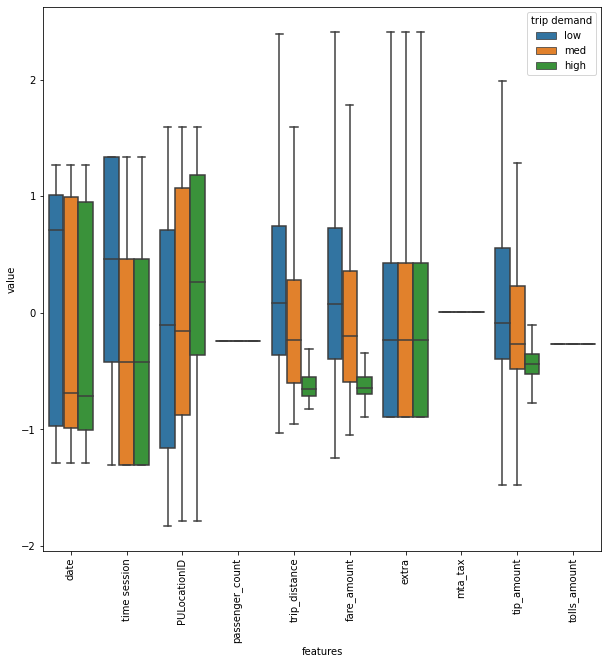

In [36]:
# first ten features
X_train_2= X_train.copy()
X_train_2["date"]= X_train["date"].apply(lambda date: int(date.strftime('%Y%m%d')))
X_train_2["time session"]= X_train_2["time session"].astype("int")
data_n_2 = (X_train_2 - X_train_2.mean()) / (X_train_2.std())              # standardization
data = pd.concat([y_train,data_n_2.iloc[:,0:10]],axis=1)
data= pd.melt(data,id_vars="trip demand",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="trip demand", data=data, showfliers=False)
plt.xticks(rotation=90)

We can immediately see that there could be a correlation between trip_distance and fare_amount but we can verify this later. We should remove the features that have a very small variance such as passenger_count, mta_tax and tolls_amount. We should also remove features that all the classes are basically the same such as extra. Interestingly, the PULocationID has a significantly different distribution corresponding to a different level of demand.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'total_amount'),
  Text(1, 0, 'congestion_surcharge'),
  Text(2, 0, 'avespeed_mileshr'),
  Text(3, 0, 'day'),
  Text(4, 0, 'DOLocationID'),
  Text(5, 0, 'total_trip_duration'),
  Text(6, 0, 'hour'),
  Text(7, 0, 'tempF'),
  Text(8, 0, 'relhumidity'),
  Text(9, 0, 'precipitation')])

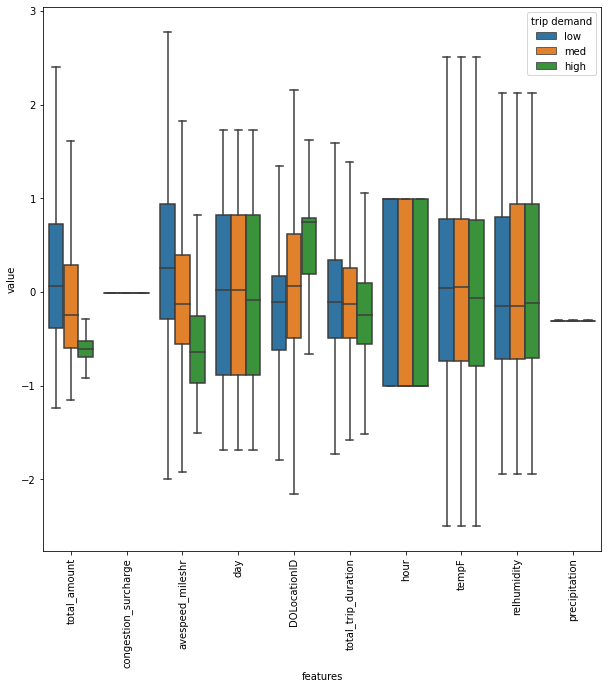

In [37]:
# first ten features             # standardization
data = pd.concat([y_train,data_n_2.iloc[:,11:]],axis=1)
data= pd.melt(data,id_vars="trip demand",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="trip demand", data=data, showfliers=False)
plt.xticks(rotation=90)

Total_amount appears to have a correlation with  trip_distance and fare_amount which distributions can see in the plot above but we can verify this later. We should remove the features that have a very small variance such as precipitation and congestion_surcharge. We should also remove features that all the classes are basically the same such as hour. Temperature and relativehumidityis associated with having a similar distribution for the middle and high demand but a slightly different distribution for low demand. Interestingly, the DOLocationID also has a significantly different distribution corresponding to a different level of demand.

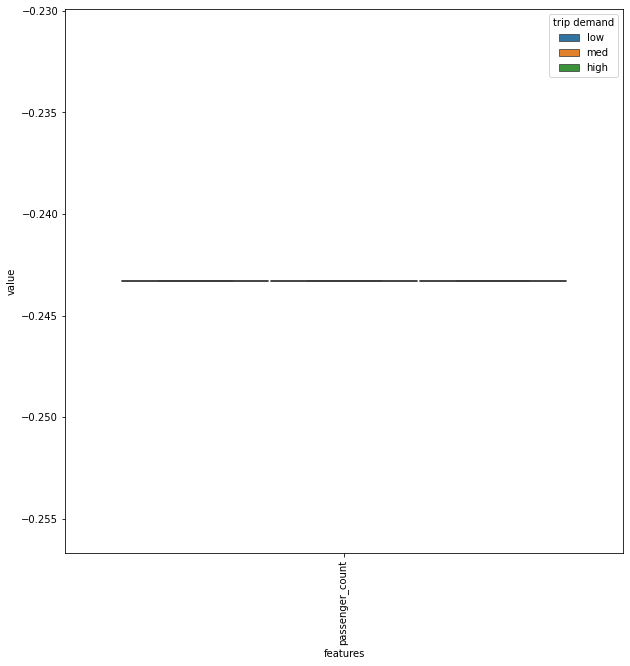

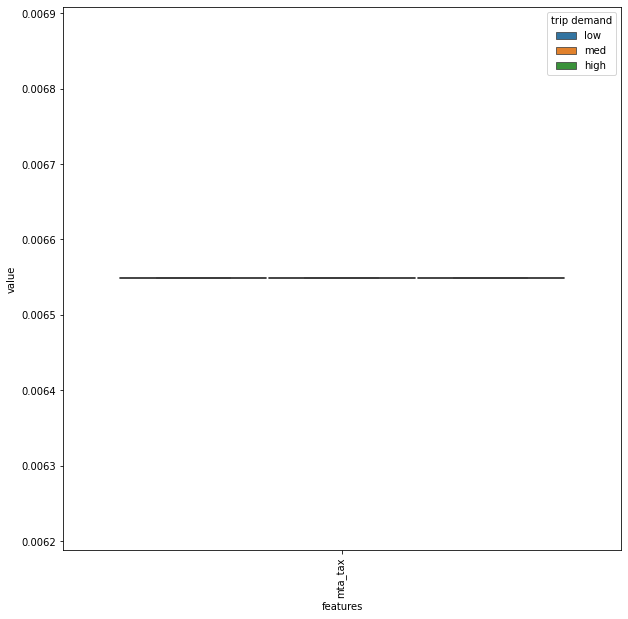

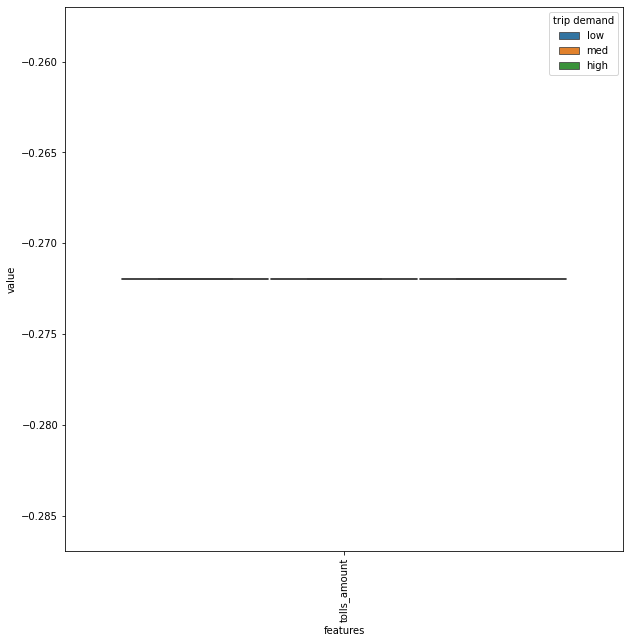

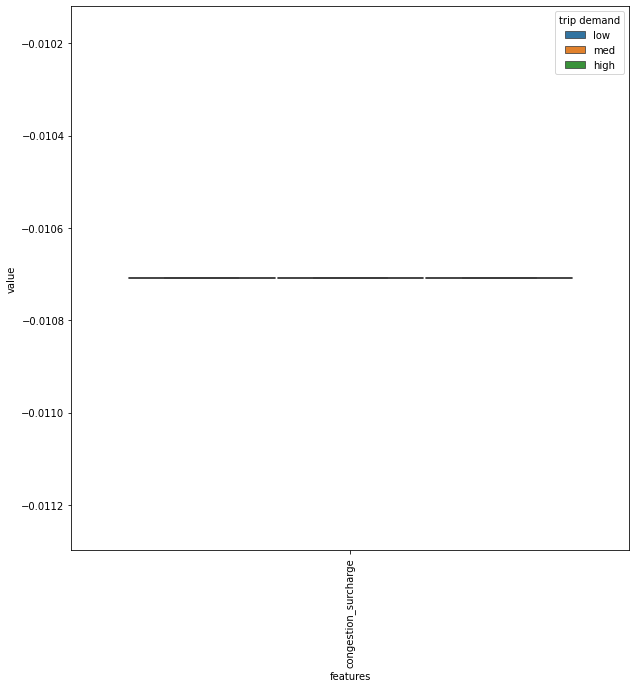

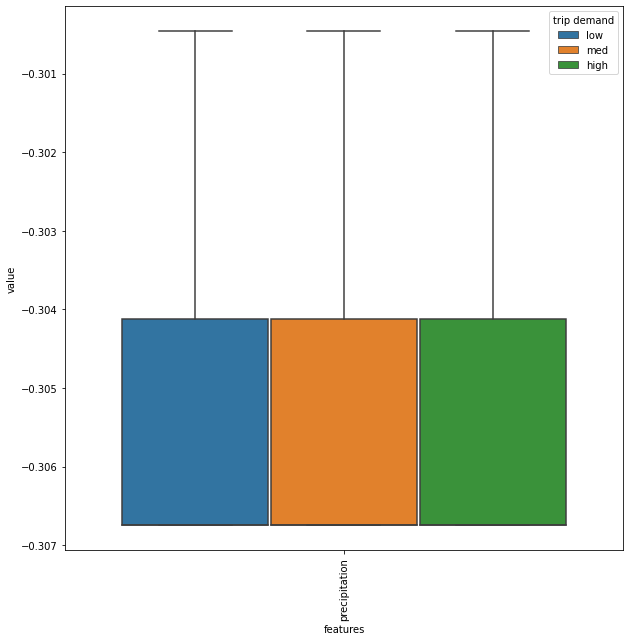

In [38]:
# first ten features             # standardization
check_names= ["passenger_count", "mta_tax", "tolls_amount",
                "congestion_surcharge", "precipitation"]
for i in check_names:
    new = data_n_2[i].copy()
    data = pd.concat([y_train,new],axis=1)
    data= pd.melt(data,id_vars="trip demand",
                        var_name="features",
                        value_name='value')
    plt.figure(figsize=(10,10))
    sns.boxplot(x="features", y="value", hue="trip demand", data=data, showfliers=False)
    plt.xticks(rotation=90)

<AxesSubplot:>

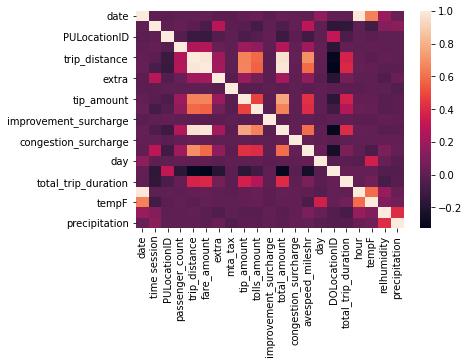

In [39]:
corr= X_train_2.corr()
sns.heatmap(corr)

VERY STRONG Correlations between
date and hour,
fare amount, trip distance, and total amount


Medium Correlation between DOLocationID and PULocationID

## Feature Selection

In [50]:
X_train_reduced = X_train.drop(columns= ["passenger_count", "mta_tax", "tolls_amount",
                              "congestion_surcharge", "extra", "hour", "fare_amount",
                              "trip_distance", "date", "precipitation", "relhumidity"])

X_test_reduced = X_test.drop(columns= ["passenger_count", "mta_tax", "tolls_amount",
                              "congestion_surcharge", "extra", "hour", "fare_amount",
                              "trip_distance", "date", "precipitation", "relhumidity"])

In [41]:
 X_train_reduced.head()

,time session,PULocationID,tip_amount,improvement_surcharge,total_amount,avespeed_mileshr,day,DOLocationID,total_trip_duration,tempF
0,1,3,0.000,0.3,51.060001,14.268638,1.0,159.0,14.233333,28.926667
1,1,4,2.000,0.3,15.960000,9.157107,1.0,145.5,15.908333,28.926667
2,1,7,4.310,0.3,25.860001,11.269419,1.0,145.0,14.808333,28.926667
3,1,12,2.325,0.3,15.375000,10.950740,1.0,135.0,28.291667,28.926667
4,1,13,2.670,0.3,18.299999,11.042945,1.0,162.0,17.358333,28.926667


<AxesSubplot:>

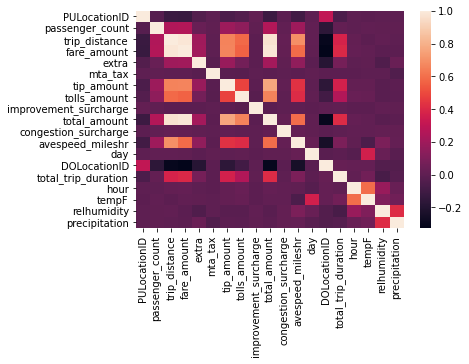

In [42]:
corr = X_train.corr()
sns.heatmap(corr)

### Save Data 

In [86]:
train_df= pd.concat([y_train,X_train_reduced],axis=1)
test_df= pd.concat([y_test,X_test_reduced],axis=1)
train_df.to_csv('../preprocessed_data/trainingdf.csv', index=False)
test_df.to_csv('../preprocessed_data/testingdf.csv', index=False)

Testing accuracy is:  1.0
Training accuracy is:  0.8518329070758738


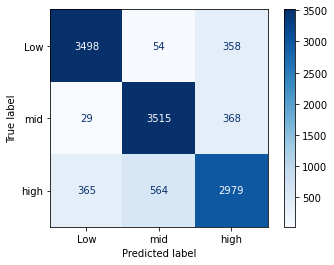

In [80]:
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train_reduced,y_train)

ac = accuracy_score(y_train,clf_rf.predict(X_train_reduced))
print('Testing accuracy is: ',ac)

ac = accuracy_score(y_test,clf_rf.predict(X_test_reduced))
print('Training accuracy is: ',ac)

#cm = confusion_matrix(y_test,clf_rf.predict(X_test_reduced))
#sns.heatmap(cm,annot=True,fmt="d",yticklabels=True)
plot_confusion_matrix(clf_rf, X_test_reduced, y_test,
                                 display_labels= ['Low', "mid","high"],
                                 cmap=plt.cm.Blues)